# Part 1

## 1a Forward Euler solver

In [3]:
%load_ext autoreload
%autoreload 2
import util
import scipy as sp
import numpy as np 
import engutil

def solve_forward_euler(F, G, u_signal, x0, fs):
    """
    Simulates a state-space system using Forward Euler.
    
    Parameters:
    F, G: System matrices
    u_signal: Array of inputs over time
    x0: Initial state vector
    fs: Sampling frequency
    """
    Ts = 1 / fs
    num_steps = len(u_signal)
    
    # 1. Initialize History Arrays
    # We need to store the state at every time step to plot it later.
    # Shape: (Number of Time Steps, Number of States)
    num_states = len(x0)
    x_history = np.zeros((num_steps, num_states))
    
    # Set current state to initial state
    x_curr = x0.copy()
    
    print(f"Simulating {num_steps} steps with Ts={Ts:.10f}s...")

    # 2. The Simulation Loop
    for n in range(num_steps):
        # Store current state
        x_history[n] = x_curr
        
        # Get current input (handle scalar or vector inputs)
        u_curr = u_signal[n]
        
        # --- THE FORMULA FROM YOUR IMAGE ---
        # Calculate the derivative (slope)
        # dx/dt = F*x + G*u
        dx = (F @ x_curr) + (G * u_curr)
        
        # Euler Step: New = Old + (Slope * StepSize)
        x_next = x_curr + (dx * Ts)
        # -----------------------------------
        
        # Update for next iteration
        x_curr = x_next
        
    return x_history


def solve_forward_euler_optimized(F, G, u_signal, x0, fs):
    Ts = 1/fs
    num_states = len(x0)
    I = np.eye(num_states)
    
    # Pre-compute Discrete Matrices
    Phi = I + (F * Ts)
    Gamma = G * Ts
    
    # Initialize
    x_history = np.zeros((len(u_signal), num_states))
    x_curr = x0.copy()
    
    # Faster Loop
    for n in range(len(u_signal)):
        x_history[n] = x_curr
        
        # Single matrix multiply + add
        x_next = (Phi @ x_curr) + (Gamma * u_signal[n])
        
        x_curr = x_next
        
    return x_history


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1b Running forward Euler with linear params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Minimum fs: 7023.90
Simulating 35119 steps with Ts=0.0000284746s...


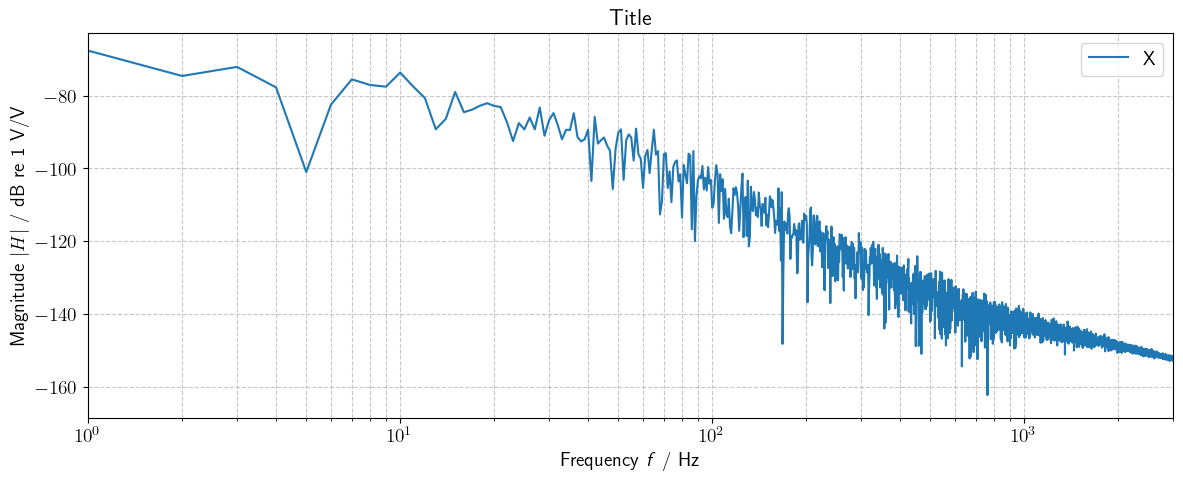

In [ ]:
%load_ext autoreload
%autoreload 2
from scipy.io import wavfile
import matplotlib.pyplot as plt

def Welch(u, X, fs):
    # print(data.keys())
    # fs = data['sample_rate'][0][0]

    # u = np.squeeze(data['voltage'])
    # d = np.squeeze(data['displacement'])
    # i = np.squeeze(data['current'])
    # v = np.squeeze(data['velocity'])
    print(f"len: {len(u)}")
    print(f"nperseg = {len(u)/25}")
    print(f"len: {len(u)/fs}")
    numsamples = len(u)
    numsecs = len(u)/fs
    numavgs = 15 # is really 2*numavgs

    #print(fs)
    # 96kHz 
    nperseg = len(u)/numavgs # 96000 #2**16
    noverlap = nperseg//2 # 2**8 #// 2
    window = 'hann'
    #nfft = 2**17
    print(f"Num avg: {2*numsamples/nperseg}")
    print(f"freq res: {fs/nperseg}")
    
    f, S_uu = scipy.signal.welch(u, fs, window, nperseg, noverlap) # , nfft=nfft)
    f, S_iu = scipy.signal.csd(u, i, fs, window, nperseg, noverlap)
    f, S_du = scipy.signal.csd(u, d, fs, window, nperseg, noverlap)
    f, S_vu = scipy.signal.csd(u, v, fs, window, nperseg, noverlap)

    mu = 0# 1e-7
    
    G_iu = S_iu/(S_uu + mu)
    G_du = S_du/(S_uu + mu)
    G_vu = S_vu/(S_uu + mu)

    return G_iu, G_du, G_vu, f


## Params from Python driven with 0.15Vrms pink noise
Bl=6.831384111697111
R_e=4.813896577382383
R_m=2.30601776771379
K_m=1714.9942000346673
L_e=0.00033049656807511955
M_m=0.019566105498948536

F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])
x0 = np.array([0,0,0])

G = np.array([
    1.0/L_e,
    0.0,
    0.0
])

x0 = np.array([
    0.0,
    0.0,
    0.0
])

minimum_fs = util.calculate_min_fs(F)
print(f"Minimum fs: {minimum_fs:.2f}")
fs = int(5*minimum_fs)

pink_noise_20Hz = util.generate_pink_noise(fs*1, fs, fmin=1)

# signal_int16 = np.int16(pink_noise_20Hz / np.max(np.abs(pink_noise_20Hz)) * 32767)
# wavfile.write("signals/pink_noise_20Hz.wav", fs, signal_int16)

x = solve_forward_euler(F, G, pink_noise_20Hz, x0, fs)
# x = solve_forward_euler_optimized(F, G, pink_noise_20Hz, x0, fs)

# current, displacement, velocity
f, i, i_db = util.make_spectrum(x[:,0], fs, scaling=True, oneside=True)
f, d, d_db = util.make_spectrum(x[:,1], fs, scaling=True, oneside=True)
f, v, v_db = util.make_spectrum(x[:,2], fs, scaling=True, oneside=True)


G_iu, G_du, G_vu, f = Welch(u, X, )

util.plot_mag([f], [d], legends=["X"], title="Title", xlim=(1,3000))

# S_iu = cross(pink_noise_20Hz, X)


In [1]:
%load_ext autoreload
%autoreload 2
from scipy.io import wavfile
import matplotlib.pyplot as plt

## Params from Python driven with 0.15Vrms pink noise
Bl=6.831384111697111
R_e=4.813896577382383
R_m=2.30601776771379
K_m=1714.9942000346673
L_e=0.00033049656807511955
M_m=0.019566105498948536

F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])
x0 = np.array([0,0,0])

G = np.array([
    1.0/L_e,
    0.0,
    0.0
])

x0 = np.array([
    0.0,
    0.0,
    0.0
])

minimum_fs = util.calculate_min_fs(F)
print(f"Minimum fs: {minimum_fs:.2f}")
fs = int(5*minimum_fs)

pink_noise_20Hz = util.generate_pink_noise(fs*1, fs, fmin=1)

# signal_int16 = np.int16(pink_noise_20Hz / np.max(np.abs(pink_noise_20Hz)) * 32767)
# wavfile.write("signals/pink_noise_20Hz.wav", fs, signal_int16)

x = solve_midpoint_optimized(F, G, pink_noise_20Hz, x0, fs)
# x = solve_forward_euler_optimized(F, G, pink_noise_20Hz, x0, fs)

# current, displacement, velocity

f, X, X_dB = util.make_spectrum(x[:,0], fs, scaling=True, oneside=True)

util.plot_mag([f], [X], legends=["X"], title="Title", xlim=(1,3000))


NameError: name 'np' is not defined